In [1]:
%matplotlib notebook
# %matplotlib inline

# Fix ROS python2 stuff
import sys
sys.path = [p for p in sys.path if "python2.7" not in p]

import numpy as np
import cv2
from matplotlib import pyplot as plt
from matplotlib import cm

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

# http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_segmentations.html
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from scipy.stats import wasserstein_distance

<IPython.core.display.Javascript object>


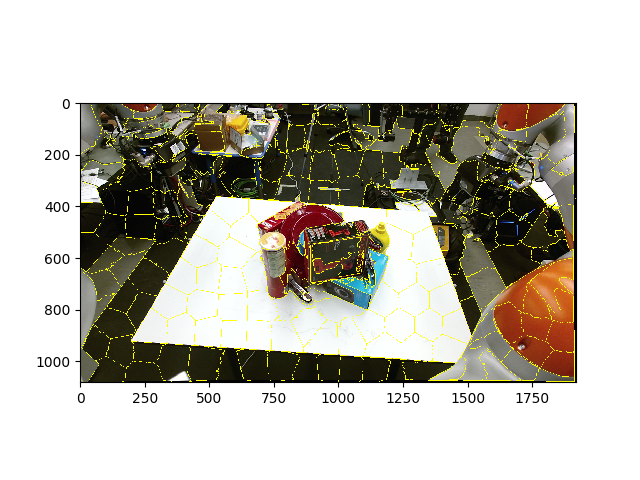

<IPython.core.display.Javascript object>


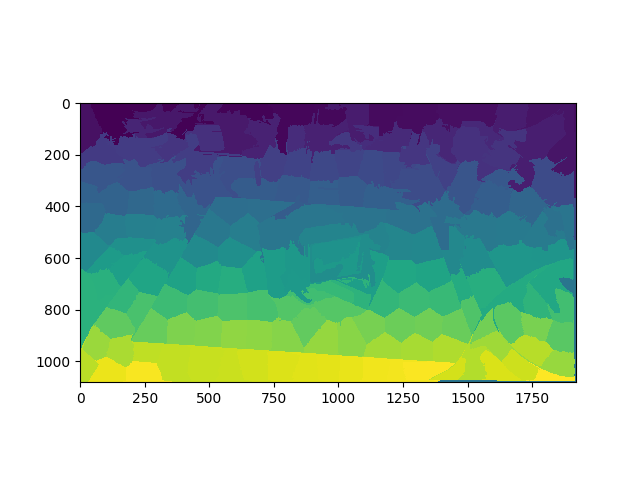

In [2]:
img1 = cv2.imread('/home/arprice/data/ycb_teleop_vive_2018-11-21-15-48-11/rgb20181121T204811.518547.jpg')
img2 = cv2.imread('/home/arprice/data/ycb_teleop_vive_2018-11-21-15-48-11/rgb20181121T204812.021465.jpg')
# img2 = cv2.imread('/home/arprice/data/ycb_teleop_vive_2018-11-21-15-48-11/rgb20181121T204912.119592.jpg')
# plt.imshow(img1[:,:,::-1])
# cv2.imshow('image', img1)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

scikit_img1 = img1[:,:,::-1]
scikit_img2 = img2[:,:,::-1]
segments_slic1 = slic(scikit_img1, n_segments=250, compactness=10, sigma=1)
segments_slic2 = slic(scikit_img2, n_segments=250, compactness=10, sigma=1)

plt.figure()
plt.imshow(mark_boundaries(scikit_img1, segments_slic1))
plt.show()
plt.figure()
plt.imshow(segments_slic1)
plt.show()

<IPython.core.display.Javascript object>


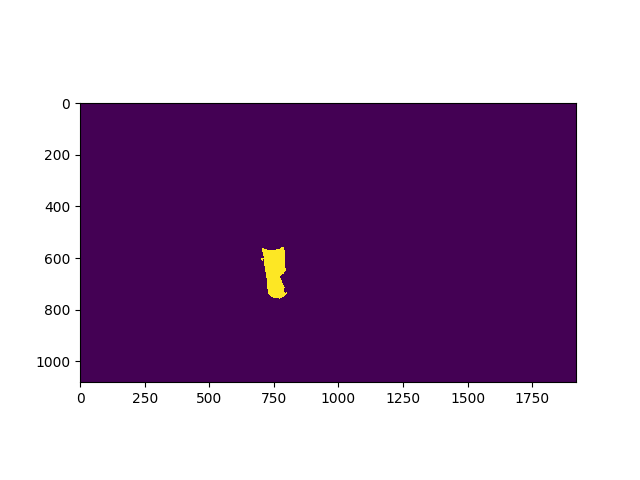

<IPython.core.display.Javascript object>


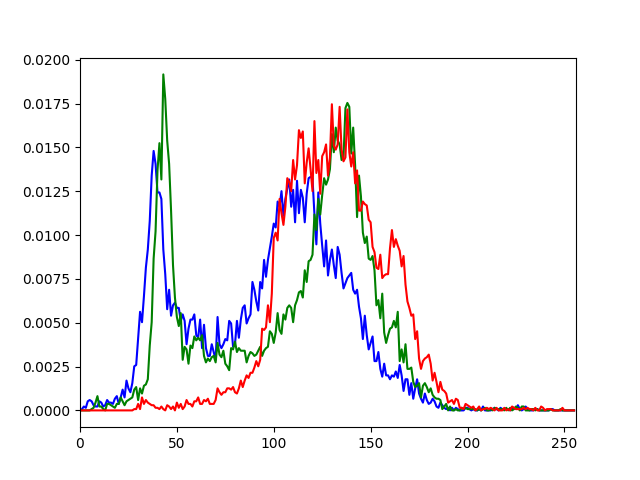

<IPython.core.display.Javascript object>


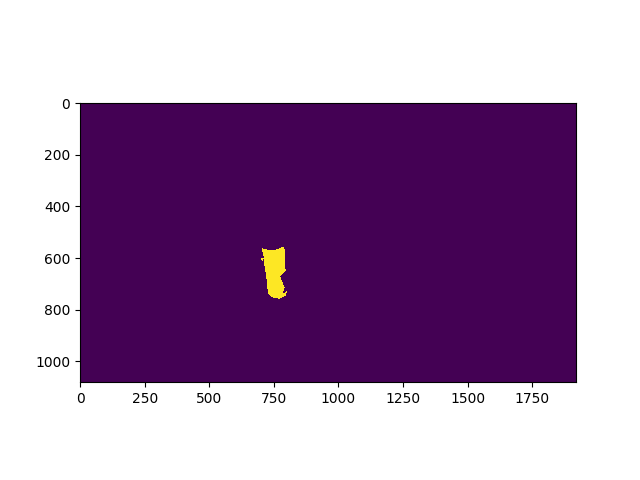

<IPython.core.display.Javascript object>


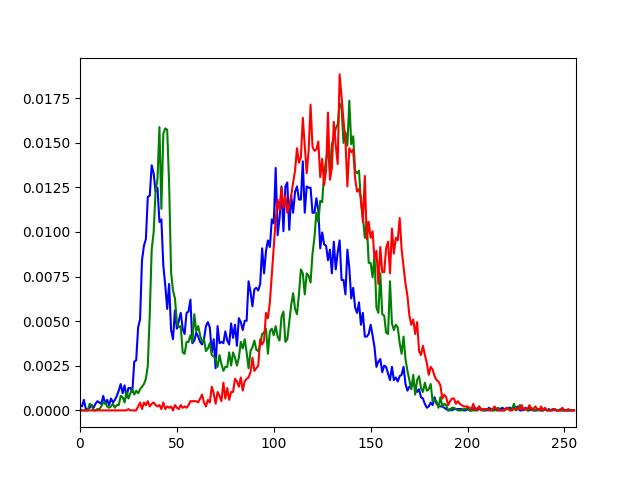

In [3]:
bgr = ('b','g','r')
def hists(img, segments, s):
    mask = np.zeros(img.shape[:2], np.uint8)
    mask[segments == s] = 1
    h = []
    for i,col in enumerate(bgr):
        hi = cv2.calcHist([img],[i],mask,[256],[0,256])
        h.append(hi / (1.0+np.sum(hi)))
    return h

def mask_hists(img, segments):
    histograms = dict()
    for s in np.unique(segments):
         histograms[s] = hists(img, segments, s)
    return histograms

def visualize_segment(img, segments, s):
    # NB:"masked" in numpy means "hidden", but "active" in cv
    mask = np.zeros(img.shape[:2], np.uint8)
    mask[segments == s] = 1
    plt.figure()
    plt.imshow(mask)
    plt.show()

    plt.figure()
    for j,col in enumerate(bgr):
        hj = cv2.calcHist([img],[j],mask,[256],[0,256])
        plt.plot(hj / (1.0+np.sum(hj)),color = col)
        plt.xlim([0,256])
    plt.show()

viz_seg1 = 97
viz_seg2 = 103
visualize_segment(img1, segments_slic1, viz_seg1)
visualize_segment(img2, segments_slic2, viz_seg2)

In [4]:
histograms1 = mask_hists(img1, segments_slic1)
histograms2 = mask_hists(img2, segments_slic2)

0.00014171312625421706
0.002630078471128172


<IPython.core.display.Javascript object>


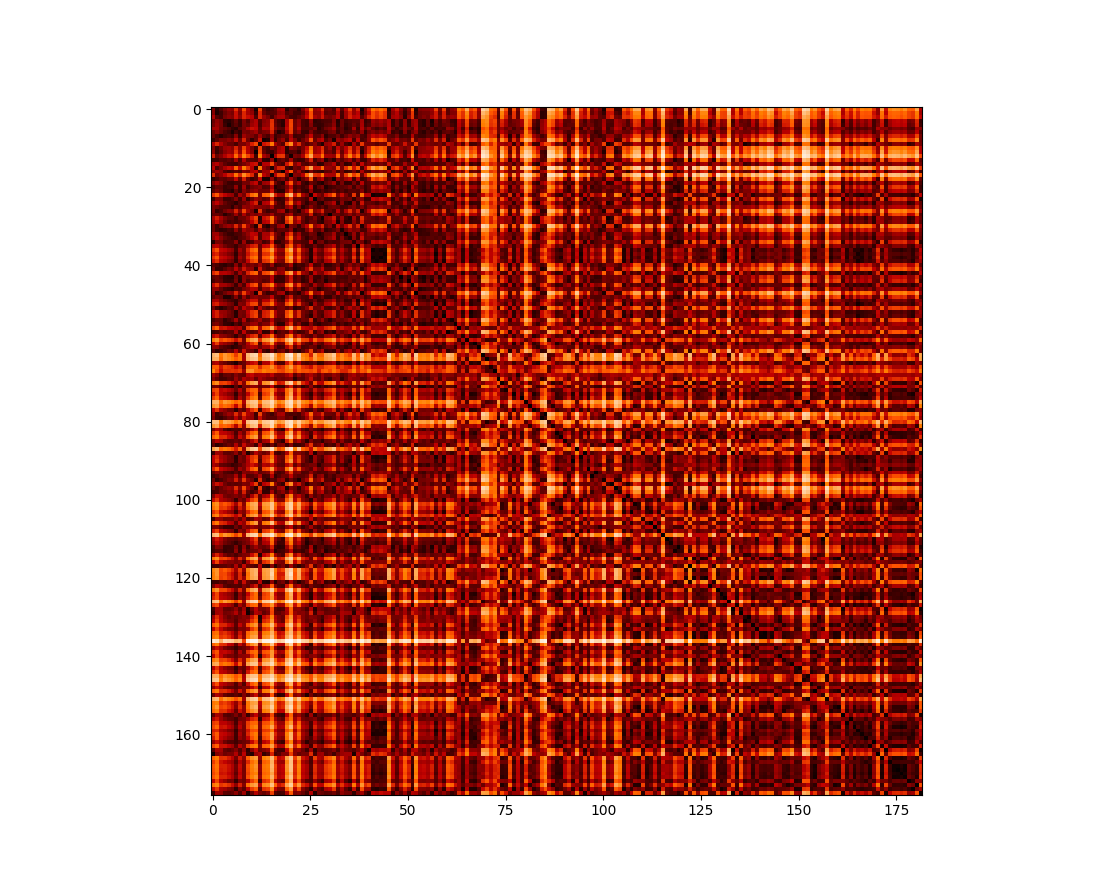

In [5]:
# print(histograms1[viz_seg1][0].flatten())
print(wasserstein_distance(histograms1[viz_seg1][0].flatten(), histograms2[viz_seg2][0].flatten()))
print(wasserstein_distance(histograms1[viz_seg1][0].flatten(), histograms2[viz_seg2-25][0].flatten()))

I = len(np.unique(segments_slic1))
J = len(np.unique(segments_slic2))
K = max(I, J)
D = np.zeros([I, J])
for i, n in enumerate(np.unique(segments_slic1)):
    for j, m in enumerate(np.unique(segments_slic2)):
        for k in range(3):
            D[i, j] += wasserstein_distance(histograms1[n][k].flatten(), histograms2[m][k].flatten())

plt.figure()
plt.imshow(D, cmap=cm.gist_heat, interpolation='nearest')
plt.show()

In [6]:
from scipy.optimize import linear_sum_assignment

row_ind, col_ind = linear_sum_assignment(D)

print(col_ind)

[ 38   1  49  56   4  47   5   7  13 101  19  11  15  16  27  45  18  20
  31 156  29  17  25  26  83  23  22  30  28  32  14  33  34  35   0  37
  41  44  43  42  58  21 111  48  50  51  53  52   3  55  57   2  66  59
  61  62  63  60  64  65  67  68  76  69  70   6  71  72  78  73  74  54
  75  77  79  80  81  82  85  84  86  87  46  88  89  90  91  93  95  94
  92  99  96  98  97 100 102 103 104 106 105 108 146 107   8 110 112 113
 114 115 116 117 119 118  12 121 124 122 123 143 126 128 127 129 130 131
 132 134 133 135 137 136 138 139 141 140 157 125 144 147 145 109 148 150
 149 152 151 153 155 154  24 142 159 160 158 161 163 162 164 165 166 167
 169 168 172 170 171 173 174 175 176 177 178 180 179 181]


In [7]:
print(row_ind[viz_seg1], '->', col_ind[viz_seg1])

97 -> 103
